In [1]:
# %matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

import torchvision
import torchvision.transforms as transforms
from matplotlib import cm

from torch.nn import Conv2d, AvgPool2d, BatchNorm2d, BatchNorm1d
import torch.nn.functional as F
from torchsummary import summary
import os
import matplotlib.pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [3]:
USE_CUDA = True
DEVICE = torch.device("cuda" if (USE_CUDA and torch.cuda.is_available()) else "cpu")
print("Using device: {}".format(DEVICE))

Using device: cuda


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=2,
                                         shuffle=False, num_workers=2)


0it [00:00, ?it/s]

9920512it [00:02, 3665690.98it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 58378.14it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:03, 538027.08it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21739.32it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.Size([64, 1, 28, 28])


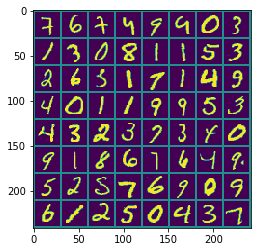

    7     6     7     4     9     9     0     3     1     3


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img[0], (0, 1)), cmap=cm.viridis)
    plt.show()
    return

# show images
print(images.shape)
imshow(torchvision.utils.make_grid(images).numpy())
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(10)))

In [0]:
class ConvNet(torch.nn.Module):
  def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=5//2)
      self.conv1_bn = BatchNorm2d(32)
      self.pool1 = nn.AvgPool2d(2, stride=2, padding=0)
      self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=5//2)
      self.conv2_bn = BatchNorm2d(32)
      self.pool2 = nn.AvgPool2d(2, stride=2, padding=0)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=5//2)
      self.conv3_bn = BatchNorm2d(64)
      self.pool3 = nn.AvgPool2d(2, stride=2, padding=0)
      self.fcn1 = nn.Linear(576, 64)
      self.fcn1_bn = BatchNorm1d(64)
      self.fcn2 = nn.Linear(64, 10)

  def forward(self, x):
      x = F.relu(self.conv1_bn(self.conv1(x)))
      x = self.pool1(x)
      x = F.relu(self.conv2_bn(self.conv2(x)))
      x = self.pool2(x)
      x = F.relu(self.conv3_bn(self.conv3(x)))
      x = self.pool3(x)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fcn1_bn(self.fcn1(x)))
      x = self.fcn2(x)
      return F.softmax(x, dim=0)

In [7]:
PATH = os.getcwd() + '/gdrive/My Drive/Colab Notebooks/CIS680/HW1/conv_net.pt'
LOADED_SAVED_MODEL = False

net = ConvNet()

try:
  net.load_state_dict(torch.load(PATH))
  print("Saved model weights loaded")
  LOADED_SAVED_MODEL = True
except:
  print("Saved model not found")

if torch.cuda.is_available():
  net.cuda()

summary(net, (1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Saved model weights loaded
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         AvgPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          25,632
       BatchNorm2d-5           [-1, 32, 14, 14]              64
         AvgPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          51,264
       BatchNorm2d-8             [-1, 64, 7, 7]             128
         AvgPool2d-9             [-1, 64, 3, 3]               0
           Linear-10                   [-1, 64]          36,928
      BatchNorm1d-11                   [-1, 64]             128
           Linear-12                   [-1, 10]             650
Total params: 115,690
Trainable params: 115,690
Non-trainable params: 0
----

In [0]:
if not LOADED_SAVED_MODEL:
  
  for epoch in range(5):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 250 == 249:    # print every 249 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 250))
              running_loss = 0.0

  print('Finished Training')
else:
  print("Using pre-trained model")

Using pre-trained model


In [0]:
MAX_ATTACKS_ON_BATCH = 2

In [0]:
def attack(image, epsilon, data_grad):
  
    sign_data_grad = data_grad.sign()
    
    # Non-decreasing I_perturbed constraint
    sign_data_grad = torch.clamp(sign_data_grad, min=0.)
    
    img_pet = image + epsilon*sign_data_grad
    
    # General image value constraint (-1, 1)
    img_pet = torch.clamp(img_pet, -1., 1.)

    return img_pet

In [0]:
def test(model, device, test_loader, epsilon, save_images=False, nsave=5):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        feed_data = data
        n_attacks = 0
        
        while n_attacks < MAX_ATTACKS_ON_BATCH:
        
          output = model(feed_data)                       
          init_conf, init_pred = output.max(1)

          loss = F.nll_loss(output, target) # Loss

          model.zero_grad() # zero grads

          loss.backward()

          data_grad = data.grad.data # get I_pet grad

          perturbed_data = attack(feed_data, epsilon, data_grad) # attack

          output = model(perturbed_data)
          final_conf, final_pred = output.max(1)
          
          # STOPPING CRITERIA. 
          high_conf_flips = (
              (torch.eq(init_pred, target) == 1) & # initial pred. right
              (torch.eq(final_pred, target) == 0) & # final pred. wrong
              (final_conf > 0.9)).nonzero() # confidence on final >90%
 
          # The number of flips with high confidence (>90%)
          n_hconf = high_conf_flips.view(-1).size(0)

          if n_hconf > 0:
            break
          else:
            feed_data = perturbed_data.detach()
            n_attacks += 1
        
        # Compute the batch accuracy
        correct_in_minibatch = torch.eq(final_pred, target).sum().item()
        correct += correct_in_minibatch

        # FANCY SAVING for report
        if save_images:
          if len(adv_examples) < nsave:
            
            # Pick a sample from the batch meeting the stopping criteria above
            flipped_preds = (
                (torch.eq(init_pred, target) == 1) &
                (torch.eq(final_pred, target) == 0)&
                (final_conf > 0.9)).nonzero().view(-1)
            
            if flipped_preds.size(0) == 0:
              continue
            
            # Multiple flips per-minibatch. Pick 1 randomly.
            idx = torch.randint(0, flipped_preds.size(0), (1,))
            selx = flipped_preds[idx]
            
            # Store the original (image.)
            original_ex = data[selx].squeeze().detach().cpu().numpy()
            # Store the flipped (adver.) image
            flipped_ex = perturbed_data[selx].squeeze().detach().cpu().numpy()
            # Store the flipped initial prediction
            init_pred_ex = init_pred[selx].item()
            # Store the flipped final prediction
            final_pred_ex = final_pred[selx].item() 
            # Store the flipped final prediction confidence
            final_conf_ex = final_conf[selx].item() 
            # Save it all
            adv_examples.append((
                init_pred_ex,
                final_pred_ex,
                final_conf_ex,
                flipped_ex,
                original_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / (float(len(test_loader) * test_loader.batch_size))
    print("Epsilon: {} | Test Acc. = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [37]:
# Not included, but epsilon = 0 is just test accuracy
epsilons = [0.1, 0.4, 0.5]
accuracies = []
examples = None

# Run test for each epsilon
for eps in epsilons:
    # Only save images for epsilon 0.2 (for report)
    if eps == 0.4:
      acc, ex = test(net, DEVICE, testloader, eps, save_images=True)
      examples = ex
    else:
      acc, _ = test(net, DEVICE, testloader, eps, save_images=False)
      
    accuracies.append(acc)

> <ipython-input-36-2c76e49ecdad>(17)test()
-> while n_attacks < MAX_ATTACKS_ON_BATCH:
(Pdb) target.requires_grad
False
(Pdb) data.shape
torch.Size([2, 1, 28, 28])
(Pdb) feed_data.shape
torch.Size([2, 1, 28, 28])
(Pdb) data.requires_grad
True
(Pdb) feed_data.requires_grad
True
(Pdb) q


BdbQuit: ignored

Images for reporting:

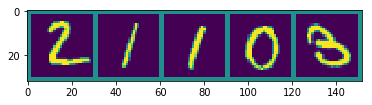

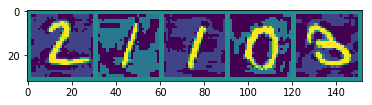

Initial predictions: [2, 1, 1, 0, 3]
Flipped (adverserial) predictions: [8, 9, 2, 7, 0]
Flipped (adverserial) confidences: [0.9703852534294128, 0.9479366540908813, 0.9993643164634705, 0.9800644516944885, 0.9954448938369751]


In [0]:
orig_grid = np.empty([len(examples), 1, 28, 28])
adv_grid = np.empty([len(examples), 1, 28, 28])

orig_preds = [None] * len(examples)
adver_preds = [None] * len(examples)
adver_confs = [None] * len(examples)

for i, ex in enumerate(examples):
  orig_preds[i] = ex[0]
  adver_preds[i] = ex[1]
  adver_confs[i] = ex[2]
  adv_grid[i, 0] = ex[3]
  orig_grid[i, 0] = ex[4]

orig_grid = torchvision.utils.make_grid(torch.from_numpy(orig_grid)).numpy()
adv_grid = torchvision.utils.make_grid(torch.from_numpy(adv_grid)).numpy()
  
# Unnormalize for display purposes
orig_grid = orig_grid / 2 + 0.5
adv_grid = adv_grid / 2 + 0.5

plt.figure()
plt.imshow(np.transpose(orig_grid[0], (0, 1)), cmap=cm.viridis)
plt.show()
# plt.imsave("OriginalImages.png",np.transpose(orig_grid[0], (0, 1)),  dpi=600)
# files.download("OriginalImages.png") 

plt.figure()
plt.imshow(np.transpose(adv_grid[0], (0, 1)), cmap=cm.viridis)
plt.show()
# plt.imsave("AdverserialImages.png", np.transpose(adv_grid[0], (0, 1)), dpi=600)
# files.download("AdverserialImages.png") 
  
print("Initial predictions: {}".format(orig_preds))
print("Flipped (adverserial) predictions: {}".format(adver_preds))
print("Flipped (adverserial) confidences: {}".format(adver_confs))

**Part 4.2 - Generating Adverserial Images of a Specific Target Class**

In [0]:
MAX_ATTACKS_ON_BATCH = 2

In [0]:
def test_adv(model, device, test_loader, epsilon, adv_target, save_images=False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, _ in test_loader:

      # Only for the forced prediction part
        force_target = torch.ones(
          data.shape[0],
          dtype=torch.int64,
          requires_grad=False) * adv_target
      
        # If doing task #2, specificy force_target as "target"
        data, force_target = data.to(device), force_target.to(device)
        data.requires_grad = True
        
        feed_data = data
        n_attacks = 0
        
        while n_attacks < MAX_ATTACKS_ON_BATCH:
        
          output = model(feed_data)                       
          init_conf, init_pred = output.max(1)

          # For forcing the adverserial, use the negative of the loss
          loss = -1 * F.nll_loss(output, force_target) 

          model.zero_grad() # zero grads

          loss.backward()
            
          data_grad = data.grad.data # get I_pet grad

          perturbed_data = attack(feed_data, epsilon, data_grad) # attack

          output = model(perturbed_data)
          final_conf, final_pred = output.max(1)
          
          # STOPPING CRITERIA. 
          high_conf_flips = (
              (torch.eq(init_pred, force_target) == 0) & # initial pred. wrong
              (torch.eq(final_pred, force_target) == 1) & # final pred. right
              (final_conf > 0.9)).nonzero() # confidence on final >90%
 
          # The number of flips with high confidence (>90%)
          n_hconf = high_conf_flips.view(-1).size(0)

          if n_hconf > 0:
            print("Hunted a rare 0.9 misclassification!")
            break
          else:
            feed_data = perturbed_data.detach()
            n_attacks += 1
        
        # Compute the batch accuracy (where correctness is now target label)
        # This will be LOW
        correct_in_minibatch = torch.eq(final_pred, force_target).sum().item()
        correct += correct_in_minibatch
        
        # FANCY SAVING for report
        if save_images:
          if len(adv_examples) < 5:
            
            # Pick a sample from the batch meeting the stopping criteria above
            flipped_preds = (
                (torch.eq(init_pred, force_target) == 0) &
                (torch.eq(final_pred, force_target) == 1) &
                (final_conf > 0.9)).nonzero().view(-1)
            
            if flipped_preds.size(0) == 0:
              continue
            else:
              print("Saving a rare 0.9 misclassification!")
            
            # Multiple flips per-minibatch. Pick 1 randomly.
            idx = torch.randint(0, flipped_preds.size(0), (1,))
            selx = flipped_preds[idx]
            
            # Store the original (image.)
            original_ex = data[selx].squeeze().detach().cpu().numpy()
            # Store the flipped (adver.) image
            flipped_ex = perturbed_data[selx].squeeze().detach().cpu().numpy()
            # Store the flipped initial prediction
            init_pred_ex = init_pred[selx].item()
            # Store the flipped final prediction
            final_pred_ex = final_pred[selx].item() 
            # Store the flipped final prediction confidence
            final_conf_ex = final_conf[selx].item() 
            # Save it all
            adv_examples.append((
                init_pred_ex,
                final_pred_ex,
                final_conf_ex,
                flipped_ex,
                original_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / (float(len(test_loader) * test_loader.batch_size))
    print("Epsilon: {} | Test Acc. = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

**And now we run our attack...**

In [50]:
# Not included, but epsilon = 0 is just test accuracy
ADV_TARGET = 8
epsilons = [0.05]
accuracies = []
examples = None

# Run test for each epsilon
for eps in epsilons:
    # Only save images for epsilon 0.4 (for report)
    if eps == 0.05:
      acc, ex = test_adv(net, DEVICE, testloader, eps, ADV_TARGET, save_images=True)
      examples = ex
    else:
      acc, _ = test_adv(net, DEVICE, testloader, eps, ADV_TARGET, save_images=False)
      
    accuracies.append(acc)

Hunted a rare 0.9 misclassification!
Saving a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Saving a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Saving a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Saving a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Saving a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
Hunted a rare 0.9 misclassification!
H

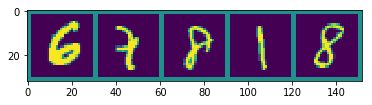

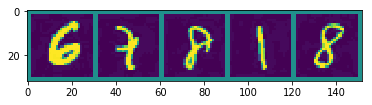

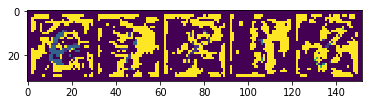

Initial predictions: [0, 9, 1, 0, 5]
Flipped (adverserial) predictions: [8, 8, 8, 8, 8]
Flipped (adverserial) confidences: [0.9999964237213135, 0.9999030828475952, 0.9722625017166138, 1.0, 1.0]


In [52]:
orig_grid = np.empty([len(examples), 1, 28, 28])
adv_grid = np.empty([len(examples), 1, 28, 28])

orig_preds = [None] * len(examples)
adver_preds = [None] * len(examples)
adver_confs = [None] * len(examples)

for i, ex in enumerate(examples):
  orig_preds[i] = ex[0]
  adver_preds[i] = ex[1]
  adver_confs[i] = ex[2]
  adv_grid[i, 0] = ex[3]
  orig_grid[i, 0] = ex[4]

orig_grid = torchvision.utils.make_grid(torch.from_numpy(orig_grid)).numpy()
adv_grid = torchvision.utils.make_grid(torch.from_numpy(adv_grid)).numpy()
diff_grid = torchvision.utils.make_grid(torch.from_numpy(adv_grid - orig_grid)).numpy()
  
# Unnormalize for display purposes
orig_grid = orig_grid / 2 + 0.5
adv_grid = adv_grid / 2 + 0.5
diff_grid = diff_grid / 2 + 0.5

plt.figure()
plt.imshow(np.transpose(orig_grid[0], (0, 1)), cmap=cm.viridis)
plt.show()
plt.imsave("OriginalImages.png",np.transpose(orig_grid[0], (0, 1)),  dpi=600)
files.download("OriginalImages.png") 

plt.figure()
plt.imshow(np.transpose(adv_grid[0], (0, 1)), cmap=cm.viridis)
plt.show()
plt.imsave("AdverserialImages.png", np.transpose(adv_grid[0], (0, 1)), dpi=600)
files.download("AdverserialImages.png") 

plt.figure()
plt.imshow(np.transpose(diff_grid[0], (0, 1)), cmap=cm.viridis)
plt.show()
plt.imsave("DiffImages.png", np.transpose(adv_grid[0], (0, 1)), dpi=600)
files.download("DiffImages.png") 

  
print("Initial predictions: {}".format(orig_preds))
print("Flipped (adverserial) predictions: {}".format(adver_preds))
print("Flipped (adverserial) confidences: {}".format(adver_confs))

 Part 4.3 - Retrain Network with Adverserial examples

In [11]:
# We want to collect 1000 adverserial examples as our training/evaluation batch
_, examples = test(net, DEVICE, testloader, 0.3, save_images=True, nsave=10000)

print("Collected {} adverserial examples".format(len(examples)))

Epsilon: 0.3 | Test Acc. = 0.5124
Collected 2698 adverserial examples


In [18]:
adv_ex = np.empty([len(examples), 1, 28, 28])
orig_preds = np.empty(len(examples))


for i, ex in enumerate(examples):
  orig_preds[i] = ex[0]
  adv_ex[i, 0] = ex[3]
  
y_train, y_test = np.split(orig_preds, [2250])
X_train, X_test = np.split(adv_ex, [2250])
batch_size = 50

print("# Train images: {}".format(len(X_train)))
print("# Test images: {}".format(len(X_test)))

# Evaluate the network on the test set
with torch.no_grad():
  output = net(torch.from_numpy(X_test).float().cuda())
  _, preds = output.max(1)
  preds = preds.cpu().numpy()
  old_acc = np.count_nonzero(np.equal(preds, y_test)) / len(orig_preds)
  print("Initial evaluation accuracy on adverserial: {}".format(old_acc))

# Train in range 
for epoch in range(5):  # loop over the dataset multiple times

  for i in range(len(X_train) // batch_size):
      # get the inputs; data is a list of [inputs, labels]
      
      inputs = torch.from_numpy(X_train[i * batch_size: (i + 1) * batch_size]).float().cuda()
      labels = torch.from_numpy(y_train[i * batch_size: (i + 1) * batch_size]).long().cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


# Re-evaluate the network on the test set
with torch.no_grad():
  output = net(torch.from_numpy(X_test).float().cuda())
  _, preds = output.max(1)
  preds = preds.cpu().numpy()
  new_acc = np.count_nonzero(np.equal(preds, y_test)) / len(orig_preds)
  print("Final evaluation accuracy on adverserial: {}".format(new_acc))
  
print("Improvement on adverserial (in fancy %)".format(new_acc / old_acc))

# Train images: 2250
# Test images: 448
Initial evaluation accuracy on adverserial: 0.16123054114158636
Final evaluation accuracy on adverserial: 0.16345441067457375
Improvement on adverserial (in fancy %)
